<a href="https://colab.research.google.com/github/yungchidanielcho/Pipeline_Corrosion_CNN/blob/main/Pipeline_and_Corrosion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
#from skimage import io
from PIL import Image 
from torch.utils.data import Dataset
import glob
import torch
import pandas as pd


# Reference: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwinyoaFucPuAhWNTN8KHcslBfQQwqsBMAJ6BAgHEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DZoZHd0Zm3RY&usg=AOvVaw1C-mkR5l5xMVuytCCMYZ2e
class CustomDataset(Dataset):
    # build wrapper for the class dataset
    # images are uploaded to google drives
    # Sizes of the images varies. The images are potraits or landscape. Most are 3-channels, at least 1 is 4-channels.

    #Paths
    classification_str ='multilabel'
    root_dir = '/content/drive/MyDrive/Pipeline Classification/'
    pipeline_path = os.path.join(root_dir,'Class_pipeline/*.*')
    pipeline_and_corrosion_path = os.path.join(root_dir, 'Class_pipeline_corrosion/*.*')
    not_pipeline_path = os.path.join(root_dir, 'Class_not_pipeline/*.*')
    corrosion_path = os.path.join(root_dir, 'Class_corrosion/*.*')
    csv_path = os.path.join(root_dir, 'class_' + classification_str + '.csv')

    def __init__(self,csv_path=csv_path, root_dir=root_dir, transform=None,classification_str=classification_str):
        self.annotations = pd.read_csv(csv_path,header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.classification = classification_str
      

    def build_csv(pipeline_path=pipeline_path, not_pipeline_path=not_pipeline_path, pipeline_and_corrosion_path=pipeline_and_corrosion_path, corrosion_path=corrosion_path, csv_path=csv_path):
        # build the csv file containing image path and class.
        # re-run if content of the folder changes
        # could have used images folder from torchvision
        
        path_and_class = {}
        #glob search for file names in a folder
        for file in glob.glob(pipeline_path): 
          path_and_class[file] = [1,0]

        for file in glob.glob(pipeline_and_corrosion_path): 
          path_and_class[file] = [1,1]

        for file in glob.glob(not_pipeline_path):
          path_and_class[file] = [0,0]
        
        for file in glob.glob(corrosion_path):
          path_and_class[file] = [0,1]

        #save csv and load it with pandas later
        with open(csv_path, 'w') as f: 
          for key in path_and_class.keys():
            f.write("%s,%s,%s\n"% (key, path_and_class[key][0],path_and_class[key][1]))

    def __len__(self):
         return len(self.annotations)

    def __getitem__(self, index): 
        img_path = self.annotations.iloc[index, 0]
        #image = io.imread(img_path) won't work because it loads image to numpy array. PIL format is expcted
        image = Image.open(img_path).convert('RGB') # there was a 4-channel image at 15
        y_label = torch.tensor(self.annotations.iloc[index, 1:3].astype(float).tolist())
        # apply image tranformation
        if self.transform:
            image = self.transform(image)
        return (image,y_label,index)


In [ ]:
CustomDataset.build_csv()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The label is tensor([1., 0.])
The index is 39
The dataset has 8040 images
There are 1069 images labeled 1 and 6971 images labeled 0 for class pipeline


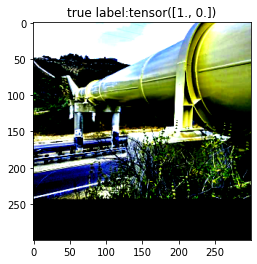

In [ ]:
# Testing the CustomDataset dataset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import ImageOps 
import numpy as np
from torchvision.transforms.functional import InterpolationMode
size = (300,300) # resize to square
interpolation = InterpolationMode.BILINEAR
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return ImageOps.expand(image, padding)

#transform = transforms.Compose(
#                                [SquarePad(),
#                                transforms.Resize(size, interpolation=InterpolationMode.BILINEAR),
#                                transforms.ToTensor(),
                                # Normalize using parameters from https://pytorch.org/docs/stable/torchvision/models.html
#                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

transform = transforms.Compose(
                            # pad to square
                            [SquarePad(),
                             transforms.RandomRotation(degrees=(-1,1)),
                             transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                             transforms.RandomResizedCrop(size, scale=(0.5, 1.0), interpolation=interpolation),
                             transforms.RandomHorizontalFlip(p=0.1),
                             transforms.RandomPerspective(distortion_scale=0.1,p=0.1),
                             transforms.ToTensor(),
                             # Normalize using parameters from https://pytorch.org/docs/stable/torchvision/models.html
                             transforms.Normalize(mean=mean, std=std)])
                             # Always put random Erasing last because normalize can't functions without data.
                             #transforms.RandomErasing(p=0.1)])


#print(f'The label is {item[1]}')
def testItem(transform=transform, item_no=39):
    '''
    This function applies transformation and shows an image and its true label
    '''
    DS1 = CustomDataset(transform=transform)
    item = DS1.__getitem__(item_no)
    plt.title('true label:{}'.format(item[1]))
    plt.imshow( item[0].permute(1, 2, 0)  ) #look up how permute works!
    print(f'The label is {item[1]}')
    print(f'The index is {item[2]}')


def testCount():
    DS1 = CustomDataset()
    num_images = len(DS1.annotations)
    num_true_images = sum(DS1.annotations.iloc[:,1])
    num_false_images = num_images - num_true_images
    print(f'The dataset has {num_images} images')
    print(f'There are {num_true_images} images labeled 1 and {num_false_images} images labeled 0 for class pipeline')

testItem()
testCount()


In [ ]:
def SaveWrongPredictions(dataset, wrong_prediction):
    '''
    
    '''
    from matplotlib.backends.backend_pdf import PdfPages

    #https://matplotlib.org/stable/faq/howto_faq.html#save-multiple-plots-to-one-pdf-file

    pdf = PdfPages(os.path.join(trial_path,'Wrong ' + dataset.classification.title() + ' Classification Predictions.pdf'))
    

    for index,label_no, pred, true_label in zip(wrong_prediction['index'],
                                        wrong_prediction['label_no'],
                                        wrong_prediction['pred'],
                                        wrong_prediction['true label']):
        img = dataset.__getitem__(int(index))[0]
        plt.figure()
        plt.title('{2} classification is wrong \n true label:{0},prediction:{1}'.format(true_label, pred,[labels[i] for i in label_no]))
        plt.imshow(img,interpolation='none')
        plt.savefig(pdf, format='pdf')
        plt.close()
    pdf.close()


In [ ]:
# calculate and plot accuracy 
def check_model(loader, model,epoch, get_index_wrong_prediction = False):
    '''
    This function performs diagnostics on the model performance by building confusion matrix. The output is a row of data for a particular epoch, which can be appended into a larger table
    Inputs:
    loader is the dataloader of either training or test set
    model is the convolutional network
    epoch is the current number of epoch (int)
    get_Image_Wrong_prediction is a binary. If true, the images results in false positive and false negative wil be saved

    '''
    print(f'Checking epoch {epoch} performance')
    def label_filter(value,filter):
        # value = torch.tensor([[1,2],[3,4],[5,6]])
        # filter = torch.tensor([[True,False],[False,True],[True,True]])
        # d[m] produce tensor([1, 4, 5, 6])
        # want[[1],[4],[5,6]]
        t = []
        for a,b in zip(value,filter):
            if any(b):
                t.append(a[b].tolist())
        return t

    # set counters to zero
    num_true_positive = 0
    num_true_negative = 0
    num_false_positive = 0
    num_false_negative = 0
    num_samples = 0

    # create empty list to store wrong prediction result for analysis
    wrong_prediction ={'index':[],'label_no':[],'pred':[],'true label':[]}

    # create empty list to store all prediction result
    all_prediction ={'index':[],'pred':[],'true label':[]}

    # create empty list for all predictions for ROC
    all_y = np.array([])
    all_prob = np.array([])

    # Image Normalization parameter
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    model.eval() # drop_out and batch_norm behaves differently in training and eval

    with torch.no_grad(): # dont track intermediate and gradients, speed up calculation
        for x,y,index in loader: # x = B,C,H,W
        #x,y,index = next(iter(test_loader))
            x = x.to(device=device)
            y = y.int().to(device=device) # B, 1
            scores = model(x) # B, 1000s check with scores.size
            prob = scores.sigmoid().detach()
            predictions = prob.round().int()

            # set tensor masks.
            # predictions, y are tensors at size batch_size, except for the last batch
            accurate_prediction = (predictions == y)
            inaccurate_prediction = torch.logical_not(accurate_prediction)
            # create a tensor of ones with the same size as prediction to make comparison
            ones = torch.ones(predictions.size(), device = device)
            # create a tensor mask where predictions  == 1
            is_true = (predictions == ones)
            not_true = torch.logical_not(is_true) # use &

            # count confusion matrix 
            num_true_positive += torch.logical_and(accurate_prediction, is_true).sum(dim=0)
            num_true_negative += torch.logical_and(accurate_prediction, not_true).sum(dim=0)
            num_false_positive += torch.logical_and(inaccurate_prediction, is_true).sum(dim=0)
            num_false_negative += torch.logical_and(inaccurate_prediction, not_true).sum(dim=0)
            num_samples += predictions.size(0)

            # store index of wrong prediction
            # create a template full of [0,1] as input for label_filter
            all_label_id = torch.tensor([0,1]*predictions.size(0)).view(predictions.size(0),2).to(device=device)
            wrong_label = all_label_id[inaccurate_prediction]

            #store all predictions
            all_prediction['index'].extend(index.tolist())
            all_prediction['pred'].extend(predictions.tolist())
            all_prediction['true label'].extend(y.tolist())

            if get_index_wrong_prediction:
                # collect if there is error in either label
                wrong_prediction['index'].extend(index[inaccurate_prediction.any(dim=1)].tolist())
                # show which label is incorrect
                wrong_prediction['label_no'].extend(label_filter(all_label_id,inaccurate_prediction))
                wrong_prediction['pred'].extend(label_filter(predictions,inaccurate_prediction))
                wrong_prediction['true label'].extend(label_filter(y,inaccurate_prediction))
                # get all probability for ROC curve
                if all_y.size == 0:
                    all_y = y.cpu().numpy()
                    all_prob = prob.cpu().numpy()
                else:
                    all_prob = np.vstack((all_prob,prob.cpu().numpy()))
                    all_y = np.vstack((all_y,y.cpu().numpy()))

        # calculate statistics  
        num_correct = (num_true_positive + num_true_negative).cpu()
        accuracy =  (num_correct / num_samples).cpu()
        precision = (num_true_positive / (num_true_positive + num_false_positive)).cpu()
        recall = (num_true_positive / (num_true_positive + num_false_negative)).cpu()
        specificity = (num_true_negative / (num_true_negative + num_false_positive)).cpu()
        false_positive_rate = (1 - specificity).cpu()

        # store statistics in dataframe
        # if tensor only has one item, use item() to transfer value from cuda to cpu
        confusion_matrices=[]
        for i in range(num_label):
            confusion_matrices.append(pd.DataFrame(data={'True Positive':num_true_positive[i].item(),
                                                    'True Negative':num_true_negative[i].item(),
                                                    'False Positive':num_false_positive[i].item(),
                                                    'False Negative':num_false_negative[i].item(), 
                                                    'Accuracy':accuracy[i].item(), 'Precision':precision[i].item(),
                                                    'Recall':recall[i].item(),
                                                    'Specificity':specificity[i].item(),
                                                    'False Positive Rate':false_positive_rate[i].item()},
                                               index=[epoch]))
    # print result for each batch    
    #print(f'Got {num_correct} / {num_samples} with accuracy {accuracy}, precision {precision}, recall {recall}, Specificity {specificity}, False Positive Rate {false_positive_rate}.')

      
    model.train()
    return confusion_matrices, wrong_prediction, all_prob, all_y, all_prediction

def plot_ROC_curve(all_y_testing,prob_testing,i,epoch):

    fpr, tpr, thresholds = metrics.roc_curve(all_y_testing[:,i], prob_testing[:,i], pos_label=None, sample_weight=None, drop_intermediate=False)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='CNN')
    display.plot()
    plt.title(dataset.classification.title() +' ' + labels[i].title() +' Classification ROC Curve for Test Set' + ' epoch ' + str(epoch))  
    plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() +' ' + labels[i].title() +' Classification ROC Curve for Test Set' + ' epoch ' + str(epoch) + '.png'))
    return 

In [ ]:
# main script
loadData()
testLoadingData()
loadModelParameters()
    namepathvars(paths)
    transformvars(trans_vars)
    modelvars(model_vars)
setModel(model_vars)
trainEvaluateModel()
    trainNetwork(Model)
    evaluatePrediction()
        makePrediction()
        getConfusionMatrix()
            getConfusionMatrixPerEpoch()
                getConfusionMatrixPerBatch()   
        getROCData()
        getFalsePredictionImageData()
saveResult()
    saveModelDict(paths)
    saveROCplot(ROCData,paths,names)
    saveConfusionMatrix(paths)
savePlot()
    saveMetricsPlots(ConfusionMatrix,paths) 
    saveFalsePredictionImage(FalsePredictionImageData,paths)

working on epoch 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 0 is 0.2666493567468768
evaluating training set
Checking epoch 0 performance
evaluating testing set
Checking epoch 0 performance
working on epoch 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 1 is 0.1531901408664205
evaluating training set
Checking epoch 1 performance
evaluating testing set
Checking epoch 1 performance
working on epoch 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 2 is 0.10901891702616756
evaluating training set
Checking epoch 2 performance
evaluating testing set
Checking epoch 2 performance
working on epoch 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 3 is 0.08947775180620904
evaluating training set
Checking epoch 3 performance
evaluating testing set
Checking epoch 3 performance
working on epoch 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 4 is 0.06370892839781432
evaluating training set
Checking epoch 4 performance
evaluating testing set
Checking epoch 4 performance
working on epoch 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 5 is 0.05558507947187701
evaluating training set
Checking epoch 5 performance
evaluating testing set
Checking epoch 5 performance
working on epoch 6


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 6 is 0.03876356210623106
evaluating training set
Checking epoch 6 performance
evaluating testing set
Checking epoch 6 performance
working on epoch 7


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 7 is 0.041113542750033295
evaluating training set
Checking epoch 7 performance
evaluating testing set
Checking epoch 7 performance
working on epoch 8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 8 is 0.03253667801089415
evaluating training set
Checking epoch 8 performance
evaluating testing set
Checking epoch 8 performance
working on epoch 9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 9 is 0.026139464128804815
evaluating training set
Checking epoch 9 performance
evaluating testing set
Checking epoch 9 performance
working on epoch 10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 10 is 0.02697678441208237
evaluating training set
Checking epoch 10 performance
evaluating testing set
Checking epoch 10 performance
working on epoch 11


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 11 is 0.025681213961268604
evaluating training set
Checking epoch 11 performance
evaluating testing set
Checking epoch 11 performance
working on epoch 12


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 12 is 0.02161724916037532
evaluating training set
Checking epoch 12 performance
evaluating testing set
Checking epoch 12 performance
working on epoch 13


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 13 is 0.02388333753333427
evaluating training set
Checking epoch 13 performance
evaluating testing set
Checking epoch 13 performance
working on epoch 14


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 14 is 0.018460744960148903
evaluating training set
Checking epoch 14 performance
evaluating testing set
Checking epoch 14 performance
working on epoch 15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 15 is 0.017183620116900947
evaluating training set
Checking epoch 15 performance
evaluating testing set
Checking epoch 15 performance
working on epoch 16


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 16 is 0.022853885096661874
evaluating training set
Checking epoch 16 performance
evaluating testing set
Checking epoch 16 performance
working on epoch 17


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 17 is 0.019087208417741666
evaluating training set
Checking epoch 17 performance
evaluating testing set
Checking epoch 17 performance
working on epoch 18


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 18 is 0.015846907384085087
evaluating training set
Checking epoch 18 performance
evaluating testing set
Checking epoch 18 performance
working on epoch 19


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 19 is 0.01789479615333469
evaluating training set
Checking epoch 19 performance
evaluating testing set
Checking epoch 19 performance


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

'\nget the epoch vs accuracy in test set curve check\ntraining vs validation set curve to determine when the model over fit check\ncompare the three models performance\nlook at failure cases \nunderstand losses check\nwhat predicted value represents?\nlearning rate check\ndata augmentation check\nROC is not over epoch check\nUse heat map to explain what the model is seeing\n'

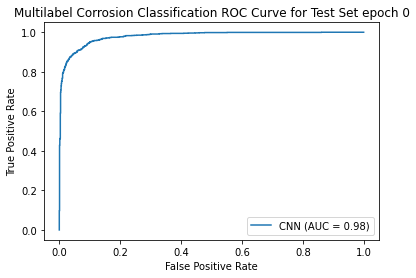

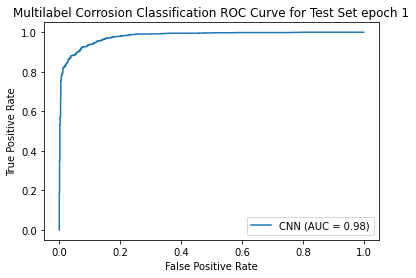

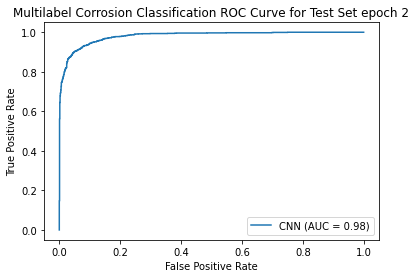

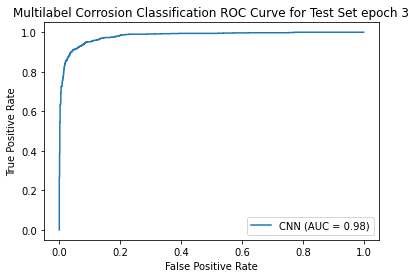

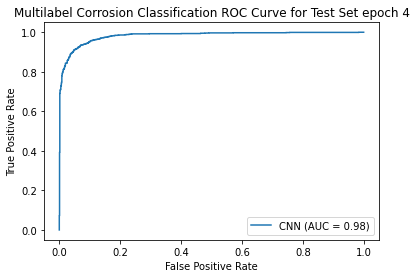

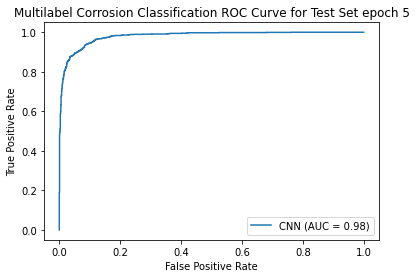

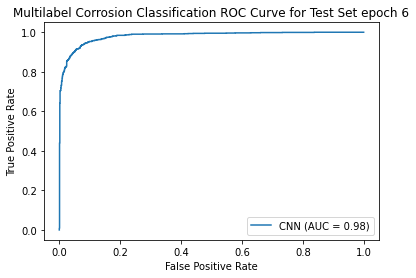

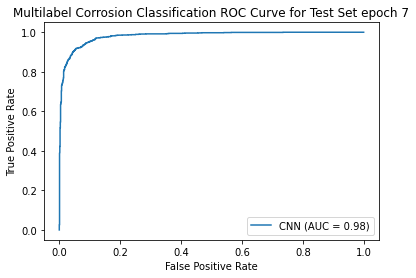

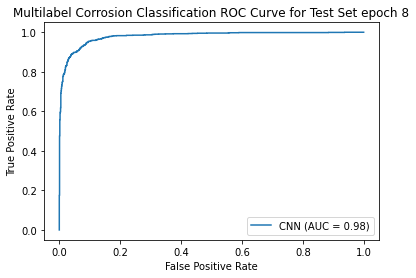

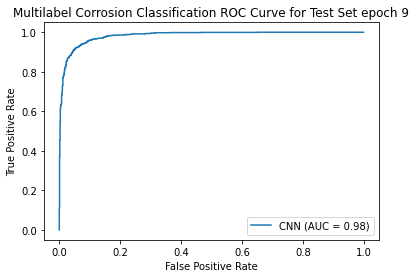

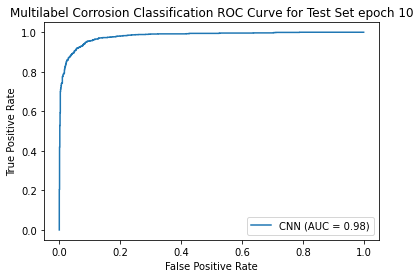

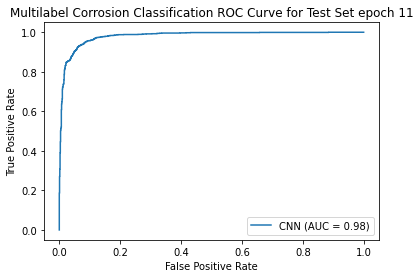

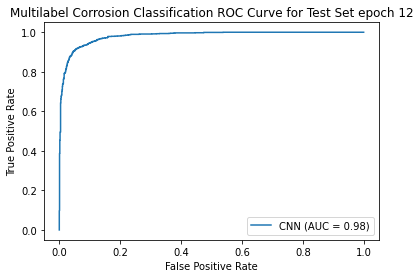

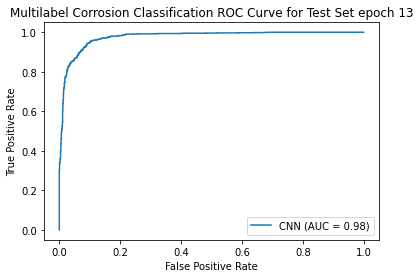

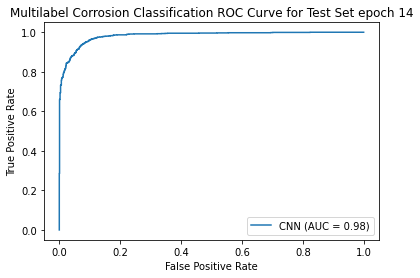

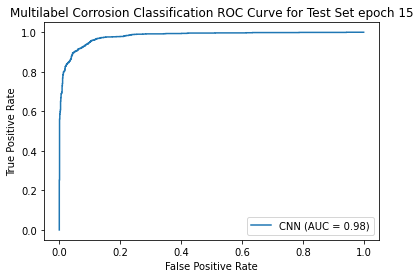

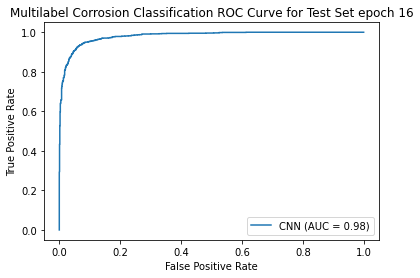

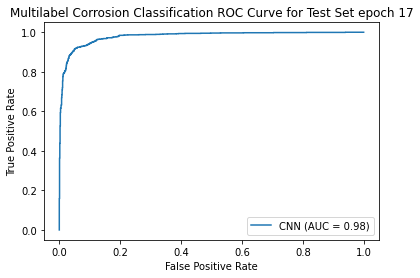

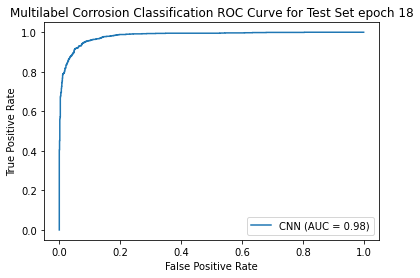

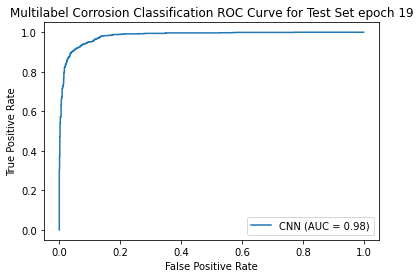

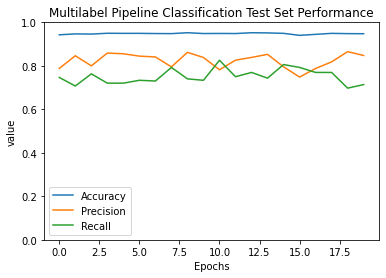

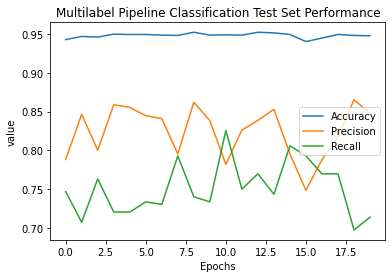

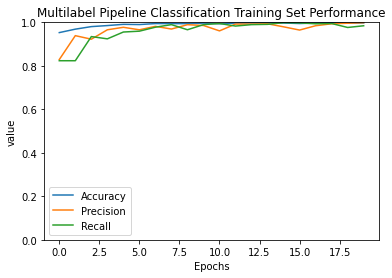

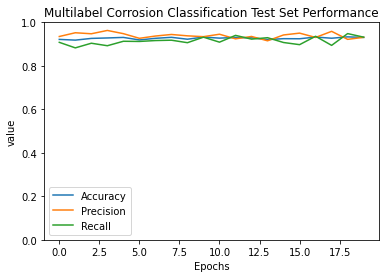

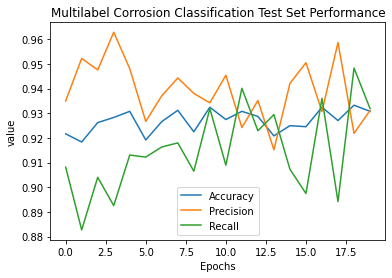

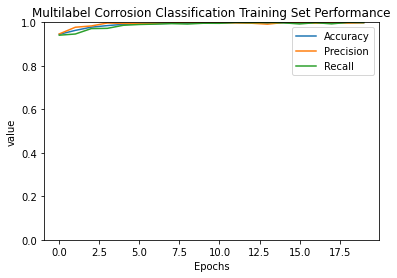

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
torch.manual_seed(16) # set seed for repeatable experiement
import torchvision
from PIL import ImageOps 
import time
from torchvision.transforms.functional import InterpolationMode
from sklearn import metrics
start_time = time.time()
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
learning_rate = 1e-4
batch_size = 32
num_epochs = 20
num_label = 2
labels = {0:'pipeline',1:'corrosion'}
split_ratio = [0.7, 0.3]

# Image Resize parameter
size = (300,300) # resize to square
interpolation = InterpolationMode.BILINEAR
# Image Normalization parameter
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Load Data
dataset = CustomDataset(transform=transform)
#Path for model
model_name = dataset.classification +' model dict'
model_extension = '.pt'
timestr = time.strftime("%Y%m%d-%H%M%S")
trial_path = os.path.join(dataset.root_dir,'Trials',timestr +' '+ model_name)
if not os.path.exists(trial_path):
    os.mkdir(trial_path)


# Paths for confusion matrix csv file for training and test set
filename_train = 'confusion matrix for training set'
filename_test = 'confusion matrix for testing set'
csv_extension = '.csv'


#Paths for wrong prediction images
filename_train_wrong_index = 'wrong index for training set'
filename_test_wrong_index = 'wrong index for test set'
filename_train_all_prediction = 'all predictions for training set'
filename_test_all_prediction = 'all predictions for testing set'
# Define Transformation
#https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/4

class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        # use ImageOps to add padding because the file is in PIL format. Torch functional pad only works on tensor
        return ImageOps.expand(image, padding)

transform = transforms.Compose(
                            # pad to square
                            [SquarePad(),
                             transforms.RandomRotation(degrees=(-1,1)),
                             transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                             transforms.RandomResizedCrop(size, scale=(0.5, 1.0), interpolation=interpolation),
                             transforms.RandomHorizontalFlip(p=0.1),
                             transforms.RandomPerspective(distortion_scale=0.1,p=0.1),
                             transforms.ToTensor(),
                             # Normalize using parameters from https://pytorch.org/docs/stable/torchvision/models.html
                             transforms.Normalize(mean=mean, std=std)])
                             # Always put random Erasing last because normalize can't functions without data.
                             #transforms.RandomErasing(p=0.1)])


# split data into 70% training 30% test
data_split = [int(round(len(dataset) * split_ratio[0])), int(round(len(dataset) * split_ratio[1]))]
train_set, test_set = torch.utils.data.random_split(dataset,data_split,generator=torch.Generator().manual_seed(16))
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=4)
# Model
# change model to 1 label
model = torchvision.models.googlenet(pretrained=True, progress=True) # output is B, 1000s
model.fc = nn.Linear(1024, 2) # change number of class to 2 in the final fully connected layer for 2 classes

model.to(device) # use gpu for faster training if available

#Loss and optimizer
criterion = nn.BCEWithLogitsLoss() # read the documentation!! also see binary entropyloss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define accuracy function here
# epochs, training accuracy, testing accuracy
# To do Train / test accuracy as a function of epochs to 20 epochs

# Create confusion matrix result container
# Each label has its own panda confusion matrix
confusion_matrices_training = []
confusion_matrices_testing = []
for i in range(num_label):
    confusion_matrices_training.append(pd.DataFrame(columns = ['True Positive', 'True Negative', 'False Positive', 'False Negative', 'Accuracy', 'Precision' , 'Recall', 'Specificity' , 'False Positive Rate']))
    confusion_matrices_testing.append(pd.DataFrame(columns = ['True Positive', 'True Negative', 'False Positive', 'False Negative', 'Accuracy', 'Precision' , 'Recall', 'Specificity' , 'False Positive Rate']))
# return confusion_matrices_training, confusion_matrices_testing

# Train Network (train_loader,model)
for epoch in range(num_epochs):
    losses = []
    print(f'working on epoch {epoch}')
    for batch_idx,(data, targets,_) in enumerate(train_loader):
        #print(f' training with batch no. {batch_idx}')
        # sent data to GPU
        data, targets = data.to(device), targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # adam step
        optimizer.step()

    #Evaluate model
    print(f'Cost at epoch {epoch} is {sum(losses) / len(losses)}')
    # only get wrong images in the last epoch
    #if epoch == num_epochs - 1:
    #    get_index_wrong_prediction = True 
    #else: 
    #    get_index_wrong_prediction = False
    get_index_wrong_prediction = True
    # for each epoch, calculate confusion matrix and append the result to container
    print('evaluating training set')
    # confusion_matrices_per_epoch is a list containing a confusion matrix panda table for each label
    confusion_matrices_per_epoch_training, wrong_prediction_training, prob_training, all_y_training, all_prediction_training = check_model(train_loader, model,epoch, get_index_wrong_prediction)
    print('evaluating testing set')
    confusion_matrices_per_epoch_testing, wrong_prediction_testing, prob_testing, all_y_testing, all_prediction_testing = check_model(test_loader, model,epoch, get_index_wrong_prediction)
    # merge confusion matrix for each epoch (row) for each label (panda table) stored in a list
    # (confusion_matrices_training,confusion_matrices_per_epoch_training,confusion_matrices_testing,confusion_matrices_per_epoch_testing)
    for i in range(num_label):
        confusion_matrices_training[i] = confusion_matrices_training[i].append(confusion_matrices_per_epoch_training[i])
        confusion_matrices_testing[i] = confusion_matrices_testing[i].append(confusion_matrices_per_epoch_testing[i])

    #save
    ROC_data_prob = 'ROC Probability'
    ROC_data_y = 'ROC true label'
    ROCdata_prob_path = os.path.join(trial_path, timestr + ' ' + ROC_data_prob +' Testing Set' + ' epoch ' + str(epoch) + '.npy')
    ROCdata_y_path = os.path.join(trial_path, timestr + ' ' + ROC_data_y + ' Testing Set' + ' epoch ' + str(epoch) + '.npy')
    np.save(ROCdata_prob_path, prob_testing)
    np.save(ROCdata_y_path,all_y_testing)
    # Plot ROC curve for current epoch
    plot_ROC_curve(all_y_testing,prob_testing,i,epoch)

    # save model (model,model_path)
    #https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb
    #https://pytorch.org/tutorials/beginner/saving_loading_models.html
    model_path = os.path.join(trial_path, timestr +' ' + model_name + ' epoch ' + str(epoch) + model_extension)
    torch.save(model.state_dict(), model_path)

    #save all predictions (wrong_index_training_path,wrong_index_test_path)
    all_prediction_training_path = os.path.join(trial_path,timestr +' ' + filename_train_all_prediction + ' epoch ' + str(epoch) + csv_extension)
    all_prediction_test_path = os.path.join(trial_path,timestr +' ' + filename_test_all_prediction + ' epoch ' + str(epoch) + csv_extension)
    pd.DataFrame(all_prediction_training).to_csv(path_or_buf=all_prediction_training_path)
    pd.DataFrame(all_prediction_testing).to_csv(path_or_buf=all_prediction_test_path)

    #save index of inaccuracte predictions (wrong_index_training_path,wrong_index_test_path)
    wrong_index_training_path = os.path.join(trial_path,timestr +' ' + filename_train_wrong_index + ' epoch ' + str(epoch) + csv_extension)
    wrong_index_test_path = os.path.join(trial_path,timestr +' ' + filename_test_wrong_index + ' epoch ' + str(epoch) + csv_extension)
    pd.DataFrame(wrong_prediction_training).to_csv(path_or_buf=wrong_index_training_path)
    pd.DataFrame(wrong_prediction_testing).to_csv(path_or_buf=wrong_index_test_path)

    # save confusion matrix (trial_path,timestr,labels,filename_train,csv_extension,confusion_matrices_training,confusion_matrices_testing)
    for i in range(num_label):
        confusion_matrix_csv_training_path = os.path.join(trial_path,timestr +' ' + labels[i].title() + ' ' + filename_train + csv_extension)
        confusion_matrix_csv_testing_path = os.path.join(trial_path,timestr +' ' + labels[i].title() + ' ' + filename_test + csv_extension)
        confusion_matrices_training[i].to_csv(path_or_buf=confusion_matrix_csv_training_path)
        confusion_matrices_testing[i].to_csv(path_or_buf=confusion_matrix_csv_testing_path)
# The index column on confusion_matrix data frame is the number of epoch, rename index to epoch

#Plot model performances

for i in range(num_label):
    # plot Accuracy, Precision, Recall for test set with ylim (0,1)
    confusion_matrices_testing[i].plot(y=['Accuracy', 'Precision', 'Recall'],
                                     title=dataset.classification.title()+ ' ' + labels[i].title() +' Classification Test Set Performance',
                                     xlabel ='Epochs',
                                     ylabel='value',
                                     legend = True,
                                     ylim = (0,1))
    plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() + ' ' + labels[i].title() +' Classification Test Set Performance' + ' ylim (0,1) ' + '.png'))
    # plot Accuracy, Precision, Recall for test set without ylim (0,1)
    confusion_matrices_testing[i].plot(y=['Accuracy', 'Precision', 'Recall'],
                                     title=dataset.classification.title()+ ' ' + labels[i].title() +' Classification Test Set Performance',
                                     xlabel ='Epochs',
                                     ylabel='value',
                                     legend = True)
    plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() + ' ' + labels[i].title() + ' Classification Test Set Performance' + '.png'))
    
    # plot Accuracy, Precision, Recall for training set with ylim (0,1)
    confusion_matrices_training[i].plot(y=['Accuracy', 'Precision', 'Recall'], title=dataset.classification.title()+ ' ' + labels[i].title() + ' Classification Training Set Performance',
                                       xlabel ='Epochs',
                                       ylabel='value',
                                       legend = True,
                                       ylim = (0,1))
    plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() + ' ' + labels[i].title() + ' Classification Training Set Performance' + ' ylim (0,1)' + '.png'))
    



    # plot Accuracy, Precision, Recall for training set
    #confusion_matrices_testing[i].plot(y=['Accuracy'],title=dataset.classification.title() + ' ' + labels[i].title() +' Classification Test Set Performance', xlabel ='Epochs', ylabel='Accuracy')
    #plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() + ' ' + labels[i].title() +' Classification Test Set Accuracy' + '.png'))


# save images of incorrect prediction
transform_plot = transforms.Compose(
                        # pad to square
                        [SquarePad(),
                        transforms.Resize((800,800)),
                        ])
dataset = CustomDataset(transform=transform_plot)
SaveWrongPredictions(dataset, wrong_prediction_testing)

end_time = time.time()
with open(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() +' time' + '.txt'), 'a') as txt:
    txt.write(f'total time taken = {end_time - start_time}\n')

#confusion_matrix_testing[1].plot(y=['Accuracy'],title='Training Set Performance', xlabel ='Epoch', ylabel='value', legend = True)
#confusion_matrix_testing[1].plot(x='False Positive Rate', y='Recall')



# Task:
'''
get the epoch vs accuracy in test set curve check
training vs validation set curve to determine when the model over fit check
compare the three models performance
look at failure cases 
understand losses check
what predicted value represents?
learning rate check
data augmentation check
ROC is not over epoch check
Use heat map to explain what the model is seeing
'''
https://try.osr.ai
https://www.nace.org/resources/general-resources/nace-podcasts/future-machine-learning-on-corrosion
https://www.materialsperformance.com/articles/material-selection-design/2020/09/the-future-of-machine-learning-on-corrosion



In [ ]:
all_prediction_testing.pop('label_no')

[]

In [ ]:
#https://stackoverflow.com/questions/61368632/display-image-in-a-pil-format-from-torch-tensor
class UnNormalize(object):
    '''
    The UnNormalize object takes in a normalized tensor and transform to an unonrmalized tensor
    '''
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m) 
            # The normalize code -> t.sub_(m).div_(s)
        return tensor * 255


In [ ]:
# Check accuracy on training to see how good our model is
import torchvision.transforms.functional as TF
  
def getImageWrongPredictions(accurate_prediction, predictions, x, y, mean, std):
    '''
    This function get the images of incorrect prediction for diagonsis for one batch in dataloader
    accurate_prediction is a binary mask for correct prediction in a batch
    x is date tensor from data loader in the dimention of B,C,H,W
    y is the label in the dimention of B
    mean is the mean parameter used in image normalization
    std is the standard deviation parameter used in image normalization
    # comment in python doc string style, PEP 8
    '''
    # collect wrong prediction for analysis
    #https://discuss.pytorch.org/t/how-to-save-wrong-prediction-results-of-a-cnn-on-mnist/66576
    
    
    # create mask for incorrect prediction
    wrong_idx = ~accurate_prediction
    # get a list of image
    wrong_samples = x[wrong_idx]
    # create a list of incorrect prediction
    wrong_preds = predictions[wrong_idx]
    # create a list of true label
    actual_preds = y[wrong_idx]
    # create the unormalize object
    unorm = UnNormalize(mean=mean, std=std)
    # create an empty list to store images
    wrong_images = []
    for i in range(wrong_idx.sum()):
        # get image
        sample = wrong_samples[i]
        # unnormalize image
        unnormlized_img = unorm(sample).byte()
        # convert from tensor to image
        img = TF.to_pil_image(unnormlized_img)
        wrong_images.append(img)
        # label management
        wrong_pred = wrong_preds[i]
        actual_pred = actual_preds[i]  
    return wrong_images

# Image Normalization parameter
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

model.eval()
wrong_training_prediction_images = []
with torch.no_grad():
    for x,y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device) # B, 1
        scores = model(x) # B, 2s check with scores.size
        _, predictions = scores.max(1)
        accurate_prediction = (predictions == y)
        print("Checking accuracy on Training Set")
        wrong_training_prediction_images.extend(getImageWrongPredictions(accurate_prediction,predictions, x, y, mean, std))

        #print("Checking accuracy on Test Set")
        #wrong_testing_prediction_images = getImageWrongPredictions(test_loader,predictions, x, y, mean, std)


#doc string (PEP 8)
# comment about function type of parameters
# what the function is supposed to do


NameError: ignored

In [ ]:
import torchvision.transforms.functional as TF


#visualize failed cases

img = wrong_testing_prediction[21] 
#
#unnormlized_img = unorm(sample)
#unnormlized_img = unnormlized_img.byte()
#img = TF.to_pil_image(unnormlized_img)
img
#plot training accuracy vs testing accuracy to detect over fitting
# visualized failed prediction images to find patterns in the fail cases.
# plot AUC
# Confusion matrix

NameError: ignored

/content/drive/MyDrive/Pipeline Classification/Class_pipeline/pipeline-a03db429e49e7d3b1a271d2f5dbe4f536c5a24ce3f0eb544c813e908489685c1.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


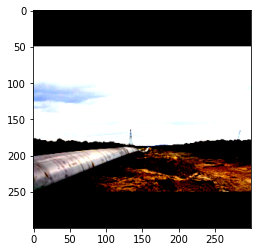

In [ ]:
from google.colab.patches import cv2_imshow

img_path = CustomDataset(transform=transform).annotations.iloc[4, 0]
print(img_path)
img = Image.open(img_path)
img.show()
image = transform(img)
plt.imshow(image.permute(1, 2, 0))
#CustomDataset(csv_path,root_dir,transform).

In [ ]:
# load and plot wrong predictions
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages
import re

# load dataset
transform_plot = transforms.Compose(
                        # pad to square
                        [SquarePad(),
                        transforms.Resize((800,800)),
                        ])
dataset = CustomDataset(transform=transform_plot)

#load wrong prediction
model_name = dataset.classification +' model dict'

timestr =  '20210227-011527'
trial_path = os.path.join(dataset.root_dir,'Trials',timestr +' '+ model_name)
csv_extension = '.csv'
filename_test_wrong_index = 'wrong index for test set'
wrong_index_test_path = os.path.join(trial_path,timestr +' ' + filename_test_wrong_index + csv_extension)
wrong_prediction = pd.read_csv(wrong_index_test_path,index_col=0)
wrong_prediction = wrong_prediction.to_dict(orient='list')

SaveWrongPredictions(dataset, wrong_prediction)






In [ ]:
filter = torch.tensor([[False,False],[False,True],[True,True]])
def label_filter(value,filter):
    # value = torch.tensor([[1,2],[3,4],[5,6]])
    # filter = torch.tensor([[True,False],[False,True],[True,True]])
    # d[m] produce tensor([1, 4, 5, 6])
    # want[[1],[4],[5,6]]
    t = []
    for a,b in zip(value,filter):
        if any(b):
            t.append(a[b].tolist())
    return t
label_filter(value,filter)

[[4], [5, 6]]

In [ ]:
# if the dataframe is contains literal tensor such as 'tensor(10)'
def GetNum(string):
    get_num = re.search('(\d+)',string).group(0)
    return int(get_num)
wrong_prediction.applymap(GetNum).to_csv(path_or_buf=wrong_index_test_path)


In [ ]:
# Create a streamlit app

!pip install streamlit

     |████████████████████████████████| 7.0MB 5.5MB/s 
     |████████████████████████████████| 163kB 47.0MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 4.6MB 54.0MB/s 
     |████████████████████████████████| 112kB 44.4MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 122kB 50.2MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp37-none-any.whl size=13448 sha256=7262bff1059eba3b23ef5b7324089e66c59ac4c115c6abb894314af6b14f9ab4
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
Successfully built blinker
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.0 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [ ]:
import streamlit as st

st.write('''
         # Pipeline and Corrosion Image Classification
         ''')
file_up = st.file_uploader("Upload an image", type="jpg")

from PIL import Image
image = Image.open(file_up)
dataset = CustomDataset(transform=transform)
item = dataset.__getitem__(item_no)
st.image(image, caption='Uploaded Image.', use_column_width=True)

2021-03-21 19:53:28.170 WARNING root: 
  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]


AttributeError: ignored

In [ ]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 21 16:09:00 2021

@author: Danielcho
"""
import os
#from skimage import io
from PIL import Image 
from torch.utils.data import Dataset
import glob
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import ImageOps 
from torch.utils.data import DataLoader
torch.manual_seed(16) # set seed for repeatable experiement
import torchvision
import numpy as np
from torchvision.transforms.functional import InterpolationMode
import streamlit as st
size = (300,300) # resize to square
interpolation = InterpolationMode.BILINEAR
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return ImageOps.expand(image, padding)
    
transform = transforms.Compose(
                            # pad to square
                            [SquarePad(),
                             transforms.RandomRotation(degrees=(-1,1)),
                             transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                             transforms.RandomResizedCrop(size, scale=(0.5, 1.0), interpolation=interpolation),
                             transforms.RandomHorizontalFlip(p=0.1),
                             transforms.RandomPerspective(distortion_scale=0.1,p=0.1),
                             transforms.ToTensor(),
                             # Normalize using parameters from https://pytorch.org/docs/stable/torchvision/models.html
                             transforms.Normalize(mean=mean, std=std)])
                             # Always put random Erasing last because normalize can't functions without data.
                             #transforms.RandomErasing(p=0.1)])
                             


# Reference: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwinyoaFucPuAhWNTN8KHcslBfQQwqsBMAJ6BAgHEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DZoZHd0Zm3RY&usg=AOvVaw1C-mkR5l5xMVuytCCMYZ2e
class CustomDataset(Dataset):
    # build wrapper for the class dataset
    # images are uploaded to google drives
    # Sizes of the images varies. The images are potraits or landscape. Most are 3-channels, at least 1 is 4-channels.

    #Paths
    classification_str ='multilabel'
    root_dir = '/content/drive/MyDrive/Pipeline Classification/'
    pipeline_path = '/content/drive/MyDrive/Pipeline Classification/Class_pipeline/*.*'
    pipeline_and_corrosion_path = '/content/drive/MyDrive/Pipeline Classification/Class_pipeline_corrosion/*.*'
    not_pipeline_path = '/content/drive/MyDrive/Pipeline Classification/Class_not_pipeline/*.*'
    corrosion_path = '/content/drive/MyDrive/Pipeline Classification/Class_corrosion/*.*'
    csv_path = '/content/drive/MyDrive/Pipeline Classification/class_' + classification_str + '.csv'

    def __init__(self,csv_path=csv_path, root_dir=root_dir, transform=None,classification_str=classification_str):
        self.annotations = pd.read_csv(csv_path,header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.classification = classification_str
      

    def build_csv(pipeline_path=pipeline_path, not_pipeline_path=not_pipeline_path, pipeline_and_corrosion_path=pipeline_and_corrosion_path, corrosion_path=corrosion_path, csv_path=csv_path):
        # build the csv file containing image path and class.
        # re-run if content of the folder changes
        # could have used images folder from torchvision
        
        path_and_class = {}
        #glob search for file names in a folder
        for file in glob.glob(pipeline_path): 
          path_and_class[file] = [1,1]

        for file in glob.glob(pipeline_and_corrosion_path): 
          path_and_class[file] = [1,1]

        for file in glob.glob(not_pipeline_path):
          path_and_class[file] = [0,0]
        
        for file in glob.glob(corrosion_path):
          path_and_class[file] = [0,1]

        #save csv and load it with pandas later
        with open(csv_path, 'w') as f: 
          for key in path_and_class.keys():
            f.write("%s,%s,%s\n"% (key, path_and_class[key][0],path_and_class[key][1]))

    def __len__(self):
         return len(self.annotations)

    def __getitem__(self, index): 
        img_path = self.annotations.iloc[index, 0]
        #image = io.imread(img_path) won't work because it loads image to numpy array. PIL format is expcted
        image = Image.open(img_path).convert('RGB') # there was a 4-channel image at 15
        y_label = torch.tensor(self.annotations.iloc[index, 1:3].astype(float).tolist())
        # apply image tranformation
        if self.transform:
            image = self.transform(image)
        return (image,y_label,index)

root_dir = '/Users/Danielcho/Google Drive/Pipeline Classification/'
dataset = CustomDataset(transform=transform)
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load model
model_name = dataset.classification +' model dict'
model_extension = '.pt'
timestr = "20210319-055841"
epoch = 10
trial_path = os.path.join(dataset.root_dir,'Trials',timestr +' '+ model_name)
model_path = os.path.join(trial_path, timestr +' ' + model_name + ' epoch ' + str(epoch) + model_extension)
model = torchvision.models.googlenet(pretrained=True, progress=True) # output is B, 1000s
model.fc = nn.Linear(1024, 2) # change number of class to 2 in the final fully connected layer for 2 classes

model.load_state_dict(torch.load(model_path,map_location=device))

model.to(device) # use gpu for faster training if available

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
print(st. __version__)


0.79.0
